# Ray Tracing

Testing how to implement ray tracing within a object with a fixed or varable refractive index.

By fixing the x-distance travelled at each step, we can remove some uncertinty in the number of itterations it takes to tranverse the radiator.

All this is easily defined by snells law:

$$ n_1 \sin(\theta_1) =  n_2 \sin(\theta_2)$$

Rearange the unknown $\theta_2$ in terms of observables:
$$ \theta_2 = \sin^{-1} \left( \frac{n1 \sin(\theta_1)}{n2}\right) $$


At each step, the ray will travel $\Delta x$ in x and $\Delta y$ in y, such that:

$$ \Delta y = \Delta x \tan(\theta_2)$$

At each step we simply apply snells law based on the distance traveled over the previous step. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.interpolate import interp1d, interp2d
from scipy.optimize import minimize

In [96]:

# Find the closet index to a value
def get_intercept(x, arr):
    return np.argmin(np.abs(x - arr))

# Generic Parabola 
def parabola(x, p0, p1, p2):
    return p2*(x)**2 + p1*(x) + p0

# Using Snells law to get the angle of refraction
def snell_theta(n1, n2, theta1):
    return np.arcsin(n1 * np.sin(theta1) / n2)


# Line
def line(x, m, c):
    return m*x +c

# Distance between a line and a parabola
# define the line in terms of the initial parameters
def dist(x, theta, y0, parms):
    y_line = line(x, np.tan(theta), y0)
    y_curve = parabola(y_line, *parms)
    return np.abs(x - y_curve)

# Get the normal vector of a generic parabola
def get_norm(x, p0, p1, p2):
    return [2*p2 * x + p1, -1]

# Use the dot product to get the angle between two vectors
def get_angle(a,b):
    norm_a = 0
    norm_b = 0
    
    dot = 0
    for i in range(len(a)):
        dot+= a[i] * b[i]
        norm_a += a[i]**2
        norm_b += b[i]**2
        
        
    return np.arccos(dot / (np.sqrt(norm_a)) / (np.sqrt(norm_b)))

In [97]:
dx = 0.1

# Start off by defining a world filled with air
n_air = 1.0003

l = 50
h = 50
y_min = -h/2
y_max = h/2
x_min = 0
x_max = l


dx_points = np.linspace(x_min, x_max, int((x_max - x_min) / dx))
dy_points = np.linspace(y_min, y_max, int((y_max - y_min) / dx))



# Coordinates at every point in the world
world_x, world_y = np.meshgrid(dx_points, dy_points, indexing="ij")


# Change the values to that of the radiator
def set_radiator(y, xmin, xmax, nvalues):
    for i in range(len(xmin)):
        iy = get_intercept(y[i], dy_points)
        imin = get_intercept(xmin[i], dx_points)
        imax = get_intercept(xmax[i], dx_points)
        n[imin:imax, iy] = nvalues[i]
        

# Defining the radiator

Define a square radiator with a variable refractive index defined by a parabola

Text(0, 0.5, 'Refractive Index')

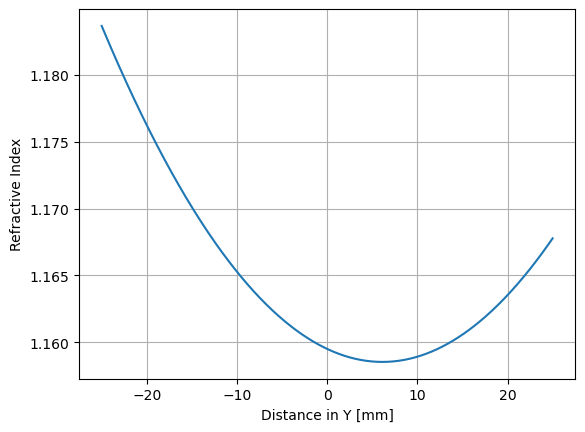

In [98]:
# Set up a Y gradient
params = [1.15855784e+00, -5.83882672e-05,  2.59534706e-05]
# params = [1.15855784e+00, 0,  0]
plt.plot(dy_points, parabola(dy_points-5, *params))
plt.grid()
plt.xlabel("Distance in Y [mm]")
plt.ylabel("Refractive Index")

In [99]:
xmin = 10*np.ones(len(dy_points))
xmax = xmin + 5
n_values = parabola(dy_points+5, *params)

# Refractive index at every point in the world
n = n_air * np.ones((dx_points.shape[0],dy_points.shape[0]))

set_radiator(dy_points, xmin, xmax, n_values)


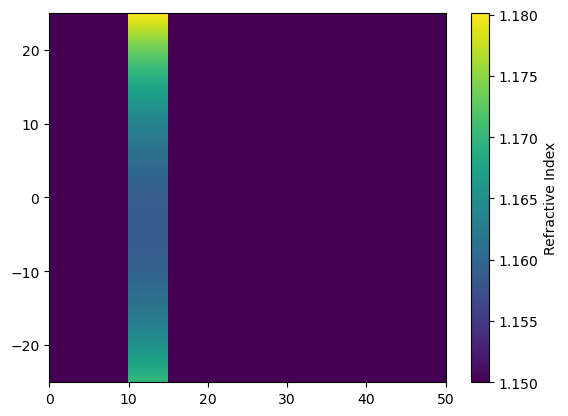

In [100]:
plt.pcolormesh(world_x, world_y, n, vmin=1.15)
plt.colorbar(label = "Refractive Index")


# Propagate a ray through the medium

Assume a fixed step size

In [101]:
# Y location
tracky = np.zeros(len(dx_points))
# Angle
thetay = np.zeros(len(dx_points))

# Initial Conditions
thetay[0] = np.deg2rad(30)
tracky[0] = 0

yloc_prev = 0

# Propegate from current to next step
for i in range(len(dx_points)-1):
#     print (i)
    # Current location
    yloc = get_intercept(tracky[i],dy_points)
    # Angle at where we're moving too
    angle = snell_theta(n[i,yloc_prev], n[i+1,yloc], thetay[i])
    thetay[i+1] = angle
    # Move in y
    tracky[i+1] = tracky[i] + dx * np.tan(angle)
    yloc_prev = yloc

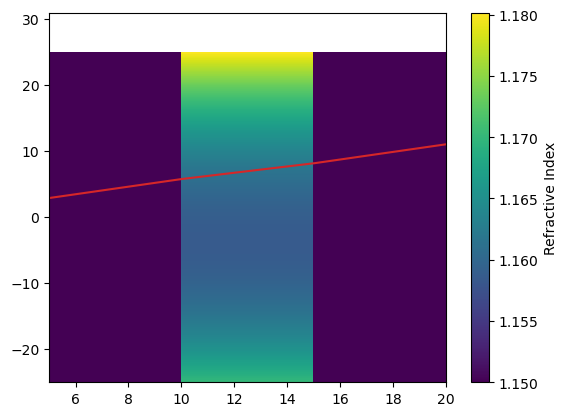

In [102]:
plt.pcolormesh(world_x, world_y, n, vmin=1.15)
plt.colorbar(label = "Refractive Index")
plt.xlim(5,20)
plt.plot(dx_points, tracky, "C3")

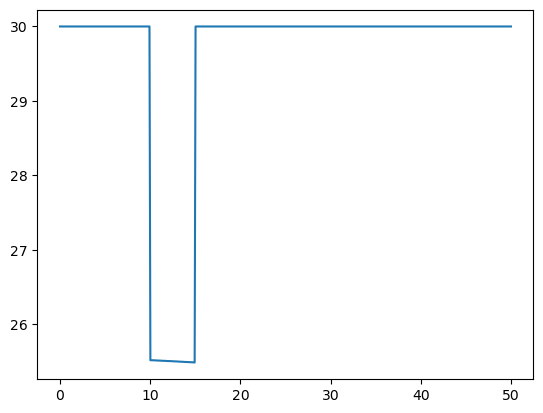

In [103]:
plt.plot(dx_points, np.rad2deg(thetay))

# The outer world isn't important

Since the outer world is homgenious, there will be no refraction until the first interface. The ray should be propagated between the origin and the interface.

Since the refractive index is described by a parabola we also don't need to store the world values of the refractive index

In [104]:
# Start out by defining the medium itself
dx = 0.001
xmax = 15
xmin = 10
y_points = np.zeros(int((xmax - xmin)/dx))
theta_points = np.zeros(y_points.shape)
n_path = np.zeros(y_points.shape)

# Initial Parameters
y0 = 0
theta0 = np.deg2rad(30)
params_material = [xmin, 0 ,0]
params_material_exit = [xmax, 0 ,0]
# Get the intersection point between the ray and the material
x_inter = minimize(dist, x0 = 10, args=(theta0, y0, [xmin, 0 ,0])).x[0]
y_inter = line(x_inter, np.tan(theta0), y0)


# Angle between ray and interface
angle_norm = get_angle([x_inter - 0, y_inter - y0], get_norm(y_inter, *params_material)) - np.pi/2

print(f"Intersection at: ({x_inter:0.2f},{y_inter : 0.2f})")
print(f"Angle of intersection: {np.rad2deg(angle_norm):0.2f} degrees")


# Propagate throught material
y_points[0] = y_inter
theta_points[0] = snell_theta(n_air, parabola(y_inter, *params), angle_norm)
n_path[0] = parabola(y_inter, *params)

print (f"Snell at the first interface: {y_points[0]:0.2f}, {np.rad2deg(theta_points[0]):0.2f}")
for i in range(len(theta_points)-1):
    y_points[i+1] = y_points[i] + dx * np.tan(theta_points[i])
    n_path[i+1] = parabola(y_points[i+1], *params)

    theta_points[i+1] = snell_theta(
        n_path[i],
        n_path[i+1],
        theta_points[i]
    )

    
# Exit the aerogel and get the angle
angle_norm_exit = get_angle([dx, y_points[-1] - y_points[-2]], get_norm(y_points[-1], *params_material_exit)) - np.pi/2
theta_exit = snell_theta(parabola(y_points[-1], *params), n_air, angle_norm_exit)
print (f"Snell at the second interface: {y_points[-1]:0.2f}, {np.rad2deg(theta_exit):0.2f}")


# Propagate to the screen
x_exit = parabola(y_points[-1], *params_material)
c_exit = y_points[-1] - np.tan(theta_exit) * x_exit
x_prop = 20
y_prop = line(x_prop, np.tan(theta_exit), c_exit)

print (f"Intersection on screen at: ({x_prop:0.2f}, {y_prop:0.2f})")



Intersection at: (10.00, 5.77)
Angle of intersection: 30.00 degrees
Snell at the first interface: 5.77, 25.56
Snell at the second interface: 8.16, 30.00
Intersection on screen at: (20.00, 13.94)


(1.159, 1.16)

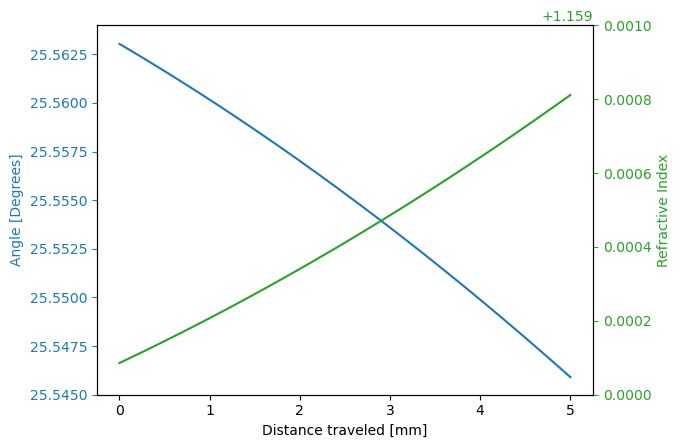

In [105]:
ax1 = plt.subplot()
ax1.plot(dx* np.arange(len(theta_points)), np.rad2deg(theta_points))
ax1.set_ylabel("Angle [Degrees]", color = "C0")
ax1.tick_params(axis='y', colors='C0')
ax1.set_xlabel("Distance traveled [mm]")
ax2 = ax1.twinx()

ax2.plot(dx* np.arange(len(theta_points)), n_path, color = "C2")
ax2.set_ylabel("Refractive Index", color = "C2")
ax2.tick_params(axis='y', colors='C2')
ax1.set_ylim(25.545, 25.564)
ax2.set_ylim(1.159, 1.16)


# Comments

This appears to work just fine for a "genericly" shaped radiator. Allowing only propagation within the radiator allows for much finer resolution.

The question remains however, how to define an irregularly shaped object?
We could define a slightly large medium that would encompass the entire radiator and set the refractive index to a non-physical value? Therefor the propagation would be NaN when we exit the physical radiator. We then find the $(x,y)$ location as the last value without a "NaN" value. 

```
mask = np.isfinite(y_points)
y_exit = y_points[mask][-1]
```
Within the loop this could be handled using a binary mask for the refractive index:
```
n_path[i+1] = parabola(y_points[i+1], *params) * inRadiator(i * dx, y_points[i+1])  

```

We could propoage to the radiator and "skip" the values where we have 0 refractive index. We can find the index where the line would intersect the true radiator and its distance within the proxy radiator. Likewise when the ray exits we can find the point on the true radiator that the beams exits and propagate from there...




In [106]:
1 + snell_theta(1.15, 0 , np.deg2rad(30))

/tmp/ipykernel_21070/3265094667.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return np.arcsin(n1 * np.sin(theta1) / n2)
/tmp/ipykernel_21070/3265094667.py:11: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin(n1 * np.sin(theta1) / n2)


nan

In [107]:
# Return whether or not the point is within the radiator
def inRadiator(x, y, param1, param2):
    return 1* (
        (x > parabola(y, *param1)) \
        & (x < parabola(y, *param2))
    )

In [108]:
x_test = 10.000
y_test = 5

n_out = parabola(y_test, *params) * inRadiator(x_test, y_test, params_material, params_material_exit)
n_in_force = parabola(y_test, *params) * inRadiator(x_test+0.00001, y_test, params_material, params_material_exit)
n_in = parabola(y_test, *params) 

print (n_in, n_out, n_in_force)

1.1589147354290001 0.0 1.1589147354290001


# Lets try propagate with the new world mask

In [109]:
# Start out by defining the medium itself
dx = 0.001

xmax = 15
xmin = 10

x_world_min = 9
x_world_max = 120

y_points = np.zeros(int((x_world_max - x_world_min)/dx))
theta_points = np.zeros(y_points.shape)
n_path = np.zeros(y_points.shape)

# Initial Parameters
y0 = 0
theta0 = np.deg2rad(30)
params_material = [xmin, 0 ,0]
params_material_exit = [xmax, 0 ,0]


# Get the intersection point between the ray and the material
x_inter = minimize(dist, x0 = 10, args=(theta0, y0, [xmin, 0 ,0])).x[0]
y_inter = line(x_inter, np.tan(theta0), y0)


# Angle between ray and interface
angle_norm = get_angle([x_inter - 0, y_inter - y0], get_norm(y_inter, *params_material)) - np.pi/2

print(f"Intersection at: ({x_inter:0.2f},{y_inter : 0.2f})")
print(f"Angle of intersection: {np.rad2deg(angle_norm):0.2f} degrees")


# Find the location in the "world" of the interception
xint = int((x_inter - x_world_min) / dx) 

# Propagate throught material
y_points[xint] = y_inter
theta_points[xint] = snell_theta(n_air, parabola(y_inter, *params), angle_norm)
n_path[xint] = parabola(y_inter, *params)

print (f"Snell at the first interface: {y_points[xint]:0.2f}, {np.rad2deg(theta_points[xint]):0.2f}")
for i in range(len(theta_points[xint:])-1):
    y_points[xint+i+1] = y_points[xint+i] + dx * np.tan(theta_points[xint+i])
    n_path[xint+i+1] = parabola(y_points[xint+i+1], *params) 
    n_path[xint+i+1] *= inRadiator(dx * (xint+i+1) + x_world_min, y_points[xint+i+1], params_material, params_material_exit)

    theta_points[xint+i+1] = snell_theta(
        n_path[xint+i],
        n_path[xint+i+1],
        theta_points[xint+i]
    )

    
# Exit the aerogel and get the angle
y_mask = np.isfinite(y_points)
angle_norm_exit = get_angle([dx, y_points[y_mask][-1] - y_points[y_mask][-2]], get_norm(y_points[y_mask][-1], *params_material_exit)) - np.pi/2
theta_exit = snell_theta(parabola(y_points[y_mask][-1], *params), n_air, angle_norm_exit)
print (f"Snell at the second interface: {y_points[y_mask][-1]:0.2f}, {np.rad2deg(theta_exit):0.2f}")


# Propagate to the screen
# Intersection at: (10.00, 5.77)
# Angle of intersection: 30.00 degrees
# Snell at the first interface: 5.77, 25.56
# Snell at the second interface: 8.16, 30.00


# Propagate to the screen
x_exit = parabola(y_points[y_mask][-1], *params_material)
c_exit = y_points[y_mask][-1] - np.tan(theta_exit) * x_exit
x_prop = 20
y_prop = line(x_prop, np.tan(theta_exit), c_exit)

print (f"Intersection on screen at: ({x_prop:0.2f}, {y_prop:0.2f})")


Intersection at: (10.00, 5.77)
Angle of intersection: 30.00 degrees
Snell at the first interface: 5.77, 25.56


/tmp/ipykernel_21070/3265094667.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return np.arcsin(n1 * np.sin(theta1) / n2)
/tmp/ipykernel_21070/3265094667.py:11: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin(n1 * np.sin(theta1) / n2)


Snell at the second interface: 8.16, 30.00
Intersection on screen at: (20.00, 13.94)


(1.159, 1.16)

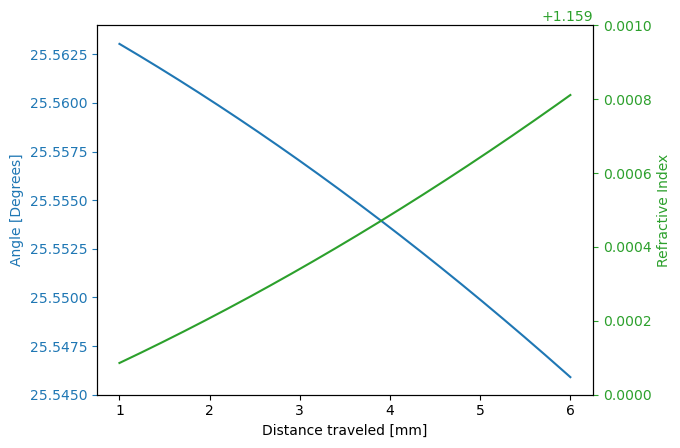

In [110]:
ax1 = plt.subplot()
ax1.plot(dx* np.arange(len(theta_points))[y_mask][xint:-1], np.rad2deg(theta_points)[y_mask][xint:-1])
ax1.set_ylabel("Angle [Degrees]", color = "C0")
ax1.tick_params(axis='y', colors='C0')
ax1.set_xlabel("Distance traveled [mm]")
ax1.set_ylim(22,30)
ax2 = ax1.twinx()

ax2.plot(dx* np.arange(len(theta_points))[y_mask][xint:-1], n_path[y_mask][xint:-1], color = "C2")
ax2.set_ylabel("Refractive Index", color = "C2")
ax2.tick_params(axis='y', colors='C2')

ax1.set_ylim(25.545, 25.564)
ax2.set_ylim(1.159, 1.16)

# Discussion

The results look entirely consistent. 

When only using the radiator:
<pre>
Intersection at: (10.00, 5.77)
Angle of intersection: 30.00 degrees
Snell at the first interface: 5.77, 25.56
Snell at the second interface: 8.16, 30.00
Intersection on screen at: (20.00, 13.94)
</pre>

When using the expanded world:
<pre>
Intersection at: (10.00, 5.77)
Angle of intersection: 30.00 degrees
Snell at the first interface: 5.77, 25.56
Snell at the second interface: 8.16, 30.00
Intersection on screen at: (20.00, 13.94)
</pre>


# Now consider a Parabola shaped radiator

For the first pass assume a constant refractive index

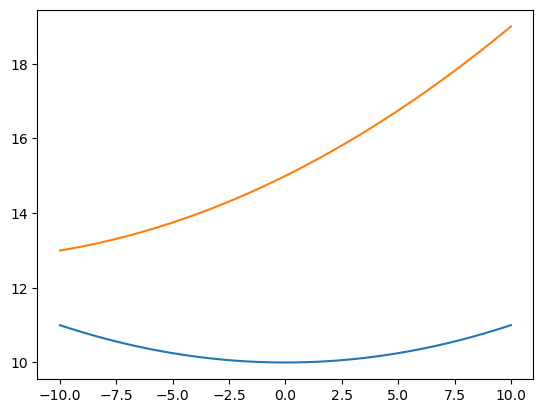

In [333]:
params_1 = [10, 1e-4, 1e-2]
params_2 = [15, 3e-1, 1e-2]
params_n = [1.15855784e+00, -5.83882672e-05,  1.09534706e-02]
# params_n = [1.15, 0, 0]

y_range = np.linspace(-10,10)
plt.plot(y_range, parabola(y_range, *params_1))
plt.plot(y_range, parabola(y_range, *params_2))

In [334]:
x_world_plot = np.linspace(0,20, 200)
y_world_plot = np.linspace(-10,10, 200)

xx_world_plot, yy_world_plot = np.meshgrid(x_world_plot, y_world_plot, indexing='ij')

# n_world_plot = np.zeros(xx_world_plot.shape)

n_world_plot = parabola(yy_world_plot, *params_n) * inRadiator(xx_world_plot, yy_world_plot, params_1, params_2)

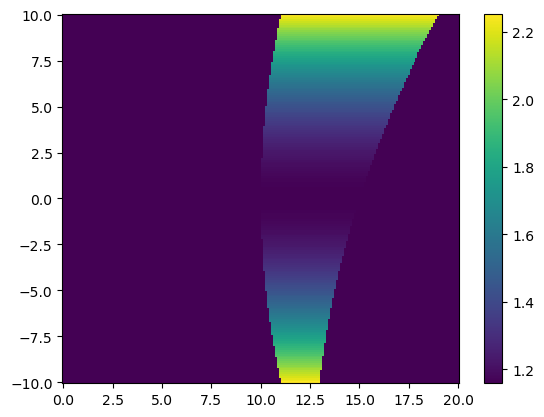

In [335]:
plt.pcolormesh(xx_world_plot, yy_world_plot, n_world_plot, vmin=1.158)

plt.colorbar()

In [336]:
# Propagate through the aerogel

# Start out by defining the medium itself
dx = 0.001



x_world_min = 7
x_world_max = 30

y_points = np.zeros(int((x_world_max - x_world_min)/dx))
theta_points = np.zeros(y_points.shape)
n_path = np.zeros(y_points.shape)

# Initial Parameters
y0 = 0
theta0 = np.deg2rad(20)
# params_material = [xmin, 0 ,0]
# params_material_exit = [xmax, 0 ,0]


# Get the intersection point between the ray and the material
x_inter = minimize(dist, x0 = 5, args=(theta0, y0, params_1)).x[0]
print (x_inter)
y_inter = line(x_inter, np.tan(theta0), y0)


# Angle between ray and interface
angle_norm = get_angle([x_inter - 0, y_inter - y0], get_norm(y_inter, *params_1)) - np.pi/2

print(f"Intersection at: ({x_inter:0.2f},{y_inter : 0.2f})")
print(f"Angle of intersection: {np.rad2deg(angle_norm):0.2f} degrees")


# Find the location in the "world" of the interception
xint = int((x_inter - x_world_min) / dx) 

# Propagate throught material
y_points[xint] = y_inter
theta_points[xint] = snell_theta(n_air, parabola(y_inter, *params_n), angle_norm)
n_path[xint] = parabola(y_inter, *params)

print (f"Snell at the first interface: {y_points[xint]:0.2f}, {np.rad2deg(theta_points[xint]):0.2f}")
for i in range(len(theta_points[xint:])-1):
    y_points[xint+i+1] = y_points[xint+i] + dx * np.tan(theta_points[xint+i])
    n_path[xint+i+1] = parabola(y_points[xint+i+1], *params_n) 
    n_path[xint+i+1] *= inRadiator(dx * (xint+i+1) + x_world_min, y_points[xint+i+1], params_1, params_2)

    theta_points[xint+i+1] = snell_theta(
        n_path[xint+i],
        n_path[xint+i+1],
        theta_points[xint+i]
    )

    
# Exit the aerogel and get the angle
y_mask = np.isfinite(y_points)

angle_norm_exit = get_angle([dx, y_points[y_mask][-1] - y_points[y_mask][-2]], 
                            get_norm(y_points[y_mask][-1], *params_2)) - np.pi/2
print (np.rad2deg(angle_norm_exit))
theta_exit = snell_theta(parabola(y_points[y_mask][-1], *params_n), n_air, angle_norm_exit)
print (f"Snell at the second interface: {y_points[y_mask][-1]:0.2f}, {np.rad2deg(theta_exit):0.2f}")



# Propagate to the screen
x_exit = parabola(y_points[y_mask][-1], *params_2)
c_exit = y_points[y_mask][-1] - np.tan(theta_exit) * x_exit
x_prop = 20
y_prop = line(x_prop, np.tan(theta_exit), c_exit)

print (f"Intersection on screen at: ({x_prop:0.2f}, {y_prop:0.2f})")


# 10.136484066426515
# Intersection at: (10.14, 3.69)
# Angle of intersection: 15.77 degrees
# Snell at the first interface: 3.69, 13.57
# 25.34050180852107
# Snell at the second interface: 4.58, 29.72
# Intersection on screen at: (20.00, 8.10)


10.136484066426515
Intersection at: (10.14, 3.69)
Angle of intersection: 15.77 degrees
Snell at the first interface: 3.69, 12.00
-11.889567370327176
Snell at the second interface: 4.87, -16.98
Intersection on screen at: (20.00, 3.86)


/tmp/ipykernel_21070/3265094667.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return np.arcsin(n1 * np.sin(theta1) / n2)
/tmp/ipykernel_21070/3265094667.py:11: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin(n1 * np.sin(theta1) / n2)


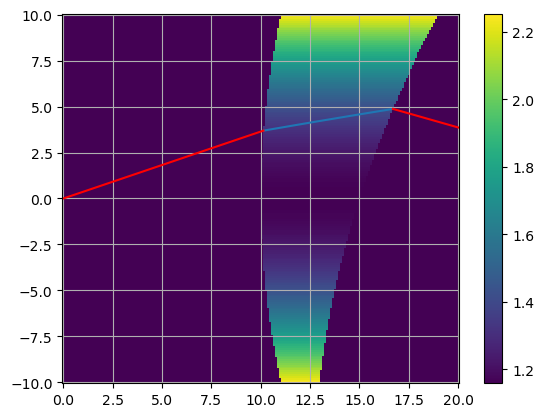

In [337]:
x_points = dx*np.arange(len(y_points)) + x_world_min

plt.pcolormesh(xx_world_plot, yy_world_plot, n_world_plot, vmin=1.158)
plt.plot(x_points[y_mask][y_points[y_mask]>0], y_points[y_mask][y_points[y_mask]>0])
plt.plot([0, x_inter], [y0, y_inter], "r")
plt.plot([x_exit, x_prop], [y_points[y_mask][-1], y_prop], "r")

plt.colorbar()
plt.grid()

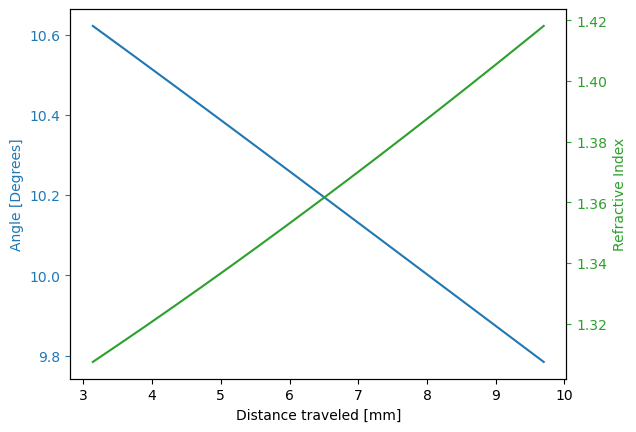

In [338]:
ax1 = plt.subplot()
ax1.plot(dx* np.arange(len(theta_points))[y_mask][xint+1:-1], np.rad2deg(theta_points)[y_mask][xint+1:-1])
ax1.set_ylabel("Angle [Degrees]", color = "C0")
ax1.tick_params(axis='y', colors='C0')
ax1.set_xlabel("Distance traveled [mm]")
# ax1.set_ylim(22,30)
ax2 = ax1.twinx()

ax2.plot(dx* np.arange(len(theta_points))[y_mask][xint+1:-1], n_path[y_mask][xint+1:-1], color = "C2")
ax2.set_ylabel("Refractive Index", color = "C2")
ax2.tick_params(axis='y', colors='C2')

# ax1.set_ylim(25.545, 25.564)
# ax2.set_ylim(1.159, 1.16)

In [340]:
np.rad2deg(theta_points)[y_mask][xint+1:-1][0], np.rad2deg(theta_points)[y_mask][xint+1:-1][-1]
# (13.783160401982496, 13.783160401982496)
# (10.621640905900477, 9.784168005391678)

(10.621640905900477, 9.784168005391678)